In [2]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, precision_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
   )

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

import warnings

import holoviews as hv

from datetime import datetime

from xgboost import XGBRFClassifier

import os

from sklearn.neural_network import MLPClassifier

import pickle

In [4]:
df=pd.read_csv('/content/lending-club-loan_ML.csv', low_memory=False)

In [5]:
def save_score(true, pred, model_name, train=True, auc_roc=None):
    timestamp = datetime.now().strftime('%Y%m')
    file_name = f"{model_name}_TestResults_{timestamp}.csv"

    clf_report = classification_report(true, pred, output_dict=True)
    accuracy = accuracy_score(true, pred) * 100
    roc_auc = roc_auc_score(true, pred) * 100
    confusion = confusion_matrix(true, pred)

    if auc_roc is not None:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })
    else:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report],
            'Confusion Matrix': [confusion.tolist()]
        })

    current_dir = os.getcwd()
    pruebas_dir = os.path.join(current_dir, 'Pruebas')
    os.makedirs(pruebas_dir, exist_ok=True)

    # Unir la ruta del directorio 'pruebas' con el nombre del archivo CSV
    file_path = os.path.join(pruebas_dir, file_name)

    result_df.to_csv(file_path, index=False)

In [6]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

        # Guardar resultados en un archivo CSV
        save_score(true, pred, model_name, train=True)

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

        # Guardar resultados en un archivo CSV
        save_score(true, pred, model_name, train=False)

In [7]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predicciones del modelo
    preds = model.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    # Calcular porcentajes
    total_correct = tp + tn
    total_errors = fp + fn
    percent_correct = total_correct / (tp + tn + fp + fn) * 100
    percent_errors = total_errors / (tp + tn + fp + fn) * 100

    # Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Imprimir resultados
    print(f"\nResults for {model_name}:")
    print(f"Total Correct: {total_correct} ({percent_correct:.2f}%)")
    print("--" * 30)
    print(f"True Positives (TP): {tp} ({tp / (tp + fn) * 100:.2f}%)")
    print(f"True Negatives (TN): {tn} ({tn / (tn + fp) * 100:.2f}%)")
    print("\nTotal Errors:")
    print(f"False Positives (FP): {fp} ({fp / (tn + fp) * 100:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn / (tp + fn) * 100:.2f}%)")

In [27]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    # Verificar si el modelo tiene el método predict_proba
    if hasattr(model, 'predict_proba'):
        # Curva ROC
        y_test_probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
        roc_auc = roc_auc_score(y_test, y_test_probs)

        # Curva P-R
        precision, recall, _ = precision_recall_curve(y_test, y_test_probs)

        # Crear la figura con dos subgráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Graficar Curva ROC
        ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('Tasa de Falsos Positivos')
        ax1.set_ylabel('Tasa de Verdaderos Positivos')
        ax1.set_title(f'Curva ROC - {model_name}')
        ax1.legend(loc='lower right')

        # Graficar Curva P-R
        ax2.plot(recall, precision, color='darkorange', lw=2, label='P-R curve')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curve')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    else:
        print(f"El modelo {model_name} no tiene el método predict_proba.")

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

# Assuming you have loaded your data into X and y
target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in the target variable using SimpleImputer
target_imputer = SimpleImputer(strategy='most_frequent')  # You can use a different strategy if needed
y_train_imputed = target_imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Create a pipeline with an imputer, scaler, and RandomForestClassifier
pipeline = Pipeline([
    ('imputer', KNNImputer()),  # Impute missing values in features using KNN
    ('scaler', StandardScaler()),
    ('rand_forest', RandomForestClassifier())
])

# Parameters for Random Forest and preprocessing steps
param_grid = {
    'imputer__n_neighbors': [3, 5, 7],
    'rand_forest__n_estimators': [10, 100, 1000],
    'rand_forest__max_features': [1, 2, 3]
}

# Grid search with the pipeline
gs_rand_forest = GridSearchCV(pipeline, param_grid, cv=7, scoring='accuracy', verbose=1, n_jobs=-1, timeout=300)

# Train the grid search with the imputed target variable
gs_rand_forest.fit(X_train, y_train_imputed)

# Results of the grid search for Random Forest
print(f'Accuracy on the training set: {gs_rand_forest.best_score_:.4f}')
print(f'Best parameters: {gs_rand_forest.best_params_}')
print('Best estimator:')
print(gs_rand_forest.best_estimator_)

# Accuracy and recall on the test set
preds_rand_forest = gs_rand_forest.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, preds_rand_forest)
recall = recall_score(y_test, preds_rand_forest)

print(f'Accuracy on the test set: {accuracy:.4f}')
print(f'Recall on the test set: {recall:.4f}')


Fitting 10 folds for each of 27 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Accuracy on the training set: 0.8850
Best parameters: {'imputer__n_neighbors': 5, 'rand_forest__max_features': 3, 'rand_forest__n_estimators': 1000}
Best estimator:
Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('rand_forest',
                 RandomForestClassifier(max_features=3, n_estimators=1000))])
Accuracy on the test set: 0.8915
Recall on the test set: 0.9978


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0.0     1.0  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    2170.0  8996.0       1.0    11166.0       11166.0
_______________________________________________
Confusion Matrix: 
 [[2170    0]
 [   0 8996]]

Test Result:
Accuracy Score: 89.15%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0          1.0  accuracy    macro avg  weighted avg
precision    0.979167     0.883229  0.891476     0.931198      0.901544
recall       0.440901     0.997787  0.891476     0.719344      0.891476
f1-score     0.608021     0.937019  0.891476     0.772520      0.874213
support    533.000000  2259.000000  0.891476  2792.000000   2792.000000
_______________________

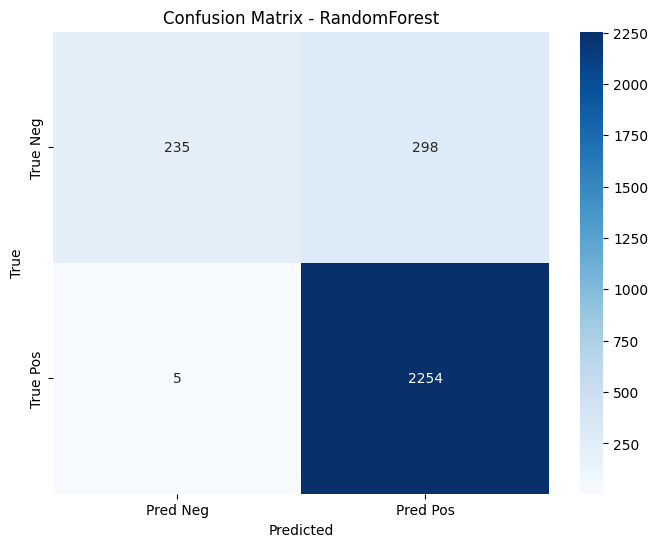


Results for RandomForest:
Total Correct: 2489 (89.15%)
------------------------------------------------------------
True Positives (TP): 2254 (99.78%)
True Negatives (TN): 235 (44.09%)

Total Errors:
False Positives (FP): 298 (55.91%)
False Negatives (FN): 5 (0.22%)


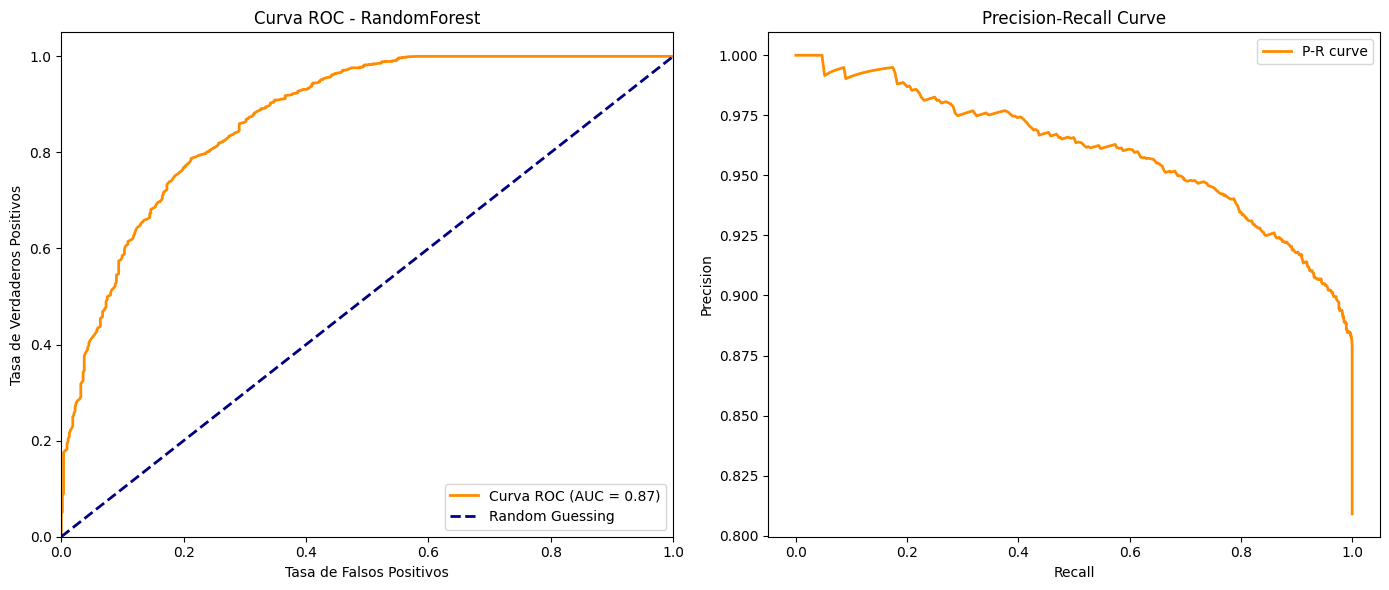

In [28]:
from sklearn.impute import SimpleImputer

# Imputar valores faltantes en la variable objetivo
target_imputer = SimpleImputer(strategy='most_frequent')  # Puedes ajustar la estrategia según tus necesidades
y_train_imputed = target_imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Obtener las predicciones del modelo
threshold = 0.5  # Umbral para convertir probabilidades en clases
train_preds_rand_forest = (gs_rand_forest.best_estimator_.predict_proba(X_train)[:, 1] > threshold).astype(int)
test_preds_rand_forest = (gs_rand_forest.best_estimator_.predict_proba(X_test)[:, 1] > threshold).astype(int)

model_name = 'RandomForest'
# Llamada a las funciones después de entrenar el modelo
print_score(y_train_imputed, train_preds_rand_forest, train=True)
print_score(y_test, test_preds_rand_forest, train=False)
plot_confusion_matrix(gs_rand_forest.best_estimator_, X_test, y_test, model_name)
plot_roc_pr_curves(gs_rand_forest.best_estimator_, X_test, y_test, model_name)
# Guardar puntuaciones
save_score(y_train_imputed, train_preds_rand_forest, model_name, train=True)
save_score(y_test, test_preds_rand_forest, model_name, train=False)

In [ ]:
# Guardar el modelo
import pickle

with open('finished_model.model_RND FRST', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['RND FRST'].best_estimator_, archivo_salida)